<a href="https://colab.research.google.com/github/tombackert/CS411-ml-for-ds/blob/main/Cats_Dogs_Wolves_Transfer_Learning_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi --list-gpus

GPU 0: Tesla T4 (UUID: GPU-1bf74b55-9d09-48b7-dd41-1b18293fdeef)


In [17]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.1 MB/s eta 0:00:00


### Downloading the Data
Ensure that you have uploaded the dataset to the colab environment.

In [3]:
!pip install gdown --quiet
import gdown
url = 'https://drive.google.com/uc?id=18pulZkIQzDHGkH-UrDzxHp_giSxerTag'
#url = 'https://drive.google.com/drive/folders/1z1sqWHyj7n-rWXGkW-nCMZjQXJLMPqCd?usp=share_link'
# url = 'https://drive.google.com/uc?id=1ImrsoqvQ3JC-iGW2znQmfkoZyL5E3icJ'
# url = 'https://drive.google.com/uc?id=1S-OJVgxKXDeS5gmqJwzUaCpXmuT4zWcu'
output = 'animals.zip'
gdown.download(url, output, quiet=True)

'animals.zip'

In [4]:
!unzip animals.zip
print("Done.")

Archive:  animals.zip
replace __MACOSX/._cats-dogs-wolves-? [y]es, [n]o, [A]ll, [N]one, [r]ename: Done.


In [5]:
!find . -name '.DS_Store' -type f -delete

train_path = 'cats-dogs-wolves-/datasets'
test_path = 'cats-dogs-wolves-/testData'
print("Paths Loaded.")

Paths Loaded.


### Importing the Software Libraries

The following code imports some software libraries necessary to execute the project.

In [6]:
%tensorflow_version 2.x
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
# from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
print("Import Success!")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Import Success!


In [7]:
image_size = (224, 224)
classes = ['cats', 'dogs', 'wolves']

train_datagen = ImageDataGenerator(validation_split=0.25) # set validation split

train_batches = train_datagen.flow_from_directory(train_path, image_size, classes=classes, batch_size=15, subset='training')
valid_batches = train_datagen.flow_from_directory(train_path, image_size, classes=classes, batch_size=8, subset='validation')
test_batches = ImageDataGenerator().flow_from_directory(test_path, image_size, classes=classes, batch_size=133)

Found 272 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 133 images belonging to 3 classes.


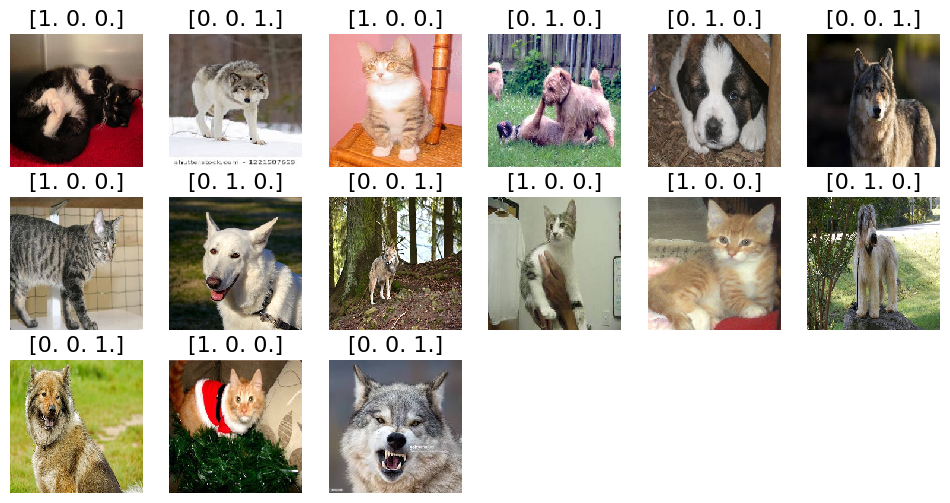

In [8]:
# plot function, used to plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(str(titles[i]), fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_batches)

# we plot these samples of images and their labels 1 batch at a time.
plots(imgs, titles=labels, rows=3)

In [9]:
vgg16_model = tensorflow.keras.applications.VGG16()

## Implementing Keras hyperparameter search (KerasTuner)

### Creating a Custom Output Model#

A new model is created copying all layers except the output layer. Notice that these layers are set to be non-trainable. Finally, a custom output layer is added to the model.  This output layer should have the same number of outputs as the number of different classes of data. The softmax activation function conditions the output to be a probability distribuiton adding up to unity. Therefore, our model will output a probability distribution among the classes as output for each input image.

In [107]:
import keras_tuner
import keras
from tensorflow.keras.layers import Dense, Dropout

In [104]:
def build_model(hp):
  model = Sequential()
  for layer in vgg16_model.layers[:-1]:
      model.add(layer)
  for layer in model.layers:
      layer.trainable = False
  model.add(Dense(len(classes), activation='softmax'))

  model.compile(
      optimizer=tensorflow.keras.optimizers.Adam(
          hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  return model

## Training the Model

Now that the model has been specified, it must be trained.




### Compiling the Model
First,the model is compiled. The performance of the model is evalued using a loss function, which increases as performance decreases. Since we are predicting a condition (yes/no), we are using cross-entropy, which is a concept from information theory. If we were instead predicting a scalar value, the correct loss function would be 'mean_squared_error'.

In [112]:
tuner_model1 = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5)

In [113]:
tuner_model1.search(train_batches, epochs=10, validation_data = valid_batches)
best_model1 = tuner_model1.get_best_models()[0]

Trial 3 Complete [00h 00m 47s]
val_accuracy: 0.6777777671813965

Best val_accuracy So Far: 0.7111111283302307
Total elapsed time: 00h 03m 03s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [115]:
tuner_model1.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
learning_rate: 0.001
Score: 0.7111111283302307

Trial 1 summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.7111111283302307

Trial 2 summary
Hyperparameters:
learning_rate: 0.01
Score: 0.6777777671813965


### Minimizing Loss

The model is now trained using the backpropagation algorithm to minimize the loss function. The training data will be passed into the model and evaluated using the loss function. Then, the model will be adjusted to decrease the loss.

Here we specifiy the epochs, which is the number of times we pass through the entire training set. These specifications are determined by experimentation with the goal of minimizing validation loss. If the epochs are too high, the model has overfit to the data (too specific). If the epochs are too low, the model has underfit to the data (too general). The validation loss must be compared to training loss to determine if the model is optimally fit to the data.


In [114]:
lr = 0.001 # learning rate according to hyperparameter search

model1 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model1.add(layer)
for layer in model1.layers:
    layer.trainable = False
model1.add(Dense(len(classes), activation='softmax'))

model1.compile(Adam(learning_rate=lr),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [30]:
model1.fit(
     train_batches,
     steps_per_epoch = train_batches.samples // 15,
     validation_data = valid_batches,
     validation_steps = valid_batches.samples // 8,
     epochs=20,
     verbose=1)
print("Trining Complete!")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 764ms/step - accuracy: 0.3729 - loss: 1.7710 - val_accuracy: 0.6705 - val_loss: 0.8856
Epoch 2/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8000 - loss: 0.8322

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8000 - loss: 0.8322 - val_accuracy: 1.0000 - val_loss: 0.7968
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7198 - loss: 0.5424 - val_accuracy: 0.7841 - val_loss: 0.4889
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4698 - val_accuracy: 1.0000 - val_loss: 0.0911
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.8663 - loss: 0.3358 - val_accuracy: 0.8750 - val_loss: 0.3543
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8000 - loss: 0.3085 - val_accuracy: 1.0000 - val_loss: 0.0110
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9233 - loss: 0.2472 - val_accuracy: 0.9091 - val_loss: 0.2750
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0395 - val_accuracy: 0.5000 - val_loss: 0.4363
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9486 - loss: 0.1488 - val_accuracy: 0.9205 - val_loss: 

## Testing the Model

To perform a final test of the model, the test data is fed through the model.  It is important to use data that was not used in training so we can test the performance accurately. The accuracy is calculated and a confusion matrix is generated.

### Test Accuracy

To calculate accuracy, the model is evaluated using the test generator specified earlier.

In [128]:
test_loss, test_acc = model1.evaluate(test_batches,
                                     steps=1,
                                     verbose=0)
print(test_loss)
print(test_acc)

1.221871018409729
0.45864662528038025


### Confusion Matrix

A confusion matrix gives more insight than just accuracy. It allows us to determine true positives, false positives, false negatives, and true negatives. The code below generates a confusion matrix for our test output

Found 133 images belonging to 3 classes.
Confusion matrix, without normalization
[[18  0  0]
 [ 2 56  3]
 [ 0  3 51]]


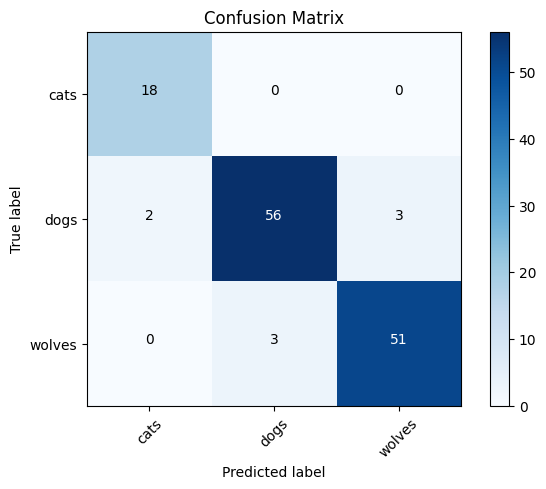

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, cm[i, j],
    #              horizontalalignment="center",
    #              color="white" if cm[i, j] > thresh else "black")

    thresh = cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test_batches.reset()
test_batches = ImageDataGenerator() \
                .flow_from_directory(test_path,
                                     target_size=(224,224),
                                     shuffle=False,
                                     batch_size=133)
test_imgs, test_labels = next(test_batches)
# test_labels = test_labels[:,0]
predictions = model1.predict(test_batches, steps=1, verbose=0)
# cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1), binary=False)
cm_plot_labels = classes
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


## Saving the fine-tuned VGG16 model

Now that the model has been trained and tested, it should be saved so we can classify new images without retraining.

In [ ]:
# model.save('animalsVGG16.h5')
# print("Model Saved.")

## Loading the fine-tuned VGG16 model

In a production environment, the model could be loaded.

In [ ]:
# model.load_weights('animalsVGG16.h5')
# print("Model Loaded.")

## Conclusion

In this notebook, using transfer learning for image classification has been demonstrated. First, the data is uploaded and connected to the Keras API. Then, the model is defined by copying a pretrained model and adding a new output layer. Once defined, the model can be trained using the appropriate loss function. Finally, the model is evaluated using a test dataset. With minimal modification, the model can be used to predict multiple classes beyond two, as well as predicting scalar values. It is encouraged to use this notebook as a templete for similar models using novel datasets.

## 2. Own CNN model

In [54]:
import keras_tuner
import keras
from tensorflow.keras.layers import Dense, Dropout


In [37]:
base_model = tensorflow.keras.applications.VGG19()

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step


In [117]:
def build_model(hp):
  model2 = Sequential()
  for layer in base_model.layers[:-1]:
      model2.add(layer)
  for layer in model2.layers:
      layer.trainable = False

  # Modify the model
  model2.add(Flatten(name='flatten_output'))
  model2.add(Dense(
      hp.Choice('units', [32, 64, 128]),
      activation='relu'))
  model2.add(Dropout(rate=0.25))
  model2.add(Dense(len(classes), activation='softmax'))

  model2.compile(
      optimizer=tensorflow.keras.optimizers.Adam(
          hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
      loss='categorical_crossentropy',
      metrics=['accuracy'])

  return model2

In [118]:
tuner_model2 = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5)

In [119]:
tuner_model2.search(train_batches, epochs=5, validation_data = valid_batches)
best_model = tuner_model2.get_best_models()[0]

Trial 5 Complete [00h 00m 46s]
val_accuracy: 0.9777777791023254

Best val_accuracy So Far: 0.9888888597488403
Total elapsed time: 00h 03m 16s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [121]:
print(best_model)

<Sequential name=sequential, built=True>


In [122]:
tuner_model2.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.9888888597488403

Trial 4 summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.9777777791023254

Trial 1 summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.9666666388511658

Trial 2 summary
Hyperparameters:
units: 64
learning_rate: 0.0001
Score: 0.9555555582046509

Trial 0 summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.9333333373069763


In [123]:
lr = 0.001 # learning rate according to hyperparameter search

model2 = Sequential()
for layer in base_model.layers[:-1]:
    model2.add(layer)
for layer in model2.layers:
    layer.trainable = False

# Modify the model
model2.add(Flatten(name='flatten_output'))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(rate=0.25))
model2.add(Dense(len(classes), activation='softmax'))

model2.compile(Adam(learning_rate=lr),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [126]:
model2.fit(
     train_batches,
     steps_per_epoch = train_batches.samples // 15,
     validation_data = valid_batches,
     validation_steps = valid_batches.samples // 8,
     epochs=20,
     verbose=1)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9835 - loss: 0.0647 - val_accuracy: 0.9545 - val_loss: 0.2324
Epoch 2/20
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0487

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0487 - val_accuracy: 1.0000 - val_loss: 5.9605e-08
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9893 - loss: 0.0278 - val_accuracy: 0.9773 - val_loss: 0.0682
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9333 - loss: 0.2802 - val_accuracy: 1.0000 - val_loss: 1.7941e-05
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9965 - loss: 0.0055 - val_accuracy: 0.9773 - val_loss: 0.0407
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.3199e-04 - val_accuracy: 1.0000 - val_loss: 8.0877e-05
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9773 - val_loss: 0.0387
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 7.5495e-04 - val_accuracy: 1.0000 - val_loss: 5.9605e-08
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accur

In [127]:
test_loss, test_acc = model2.evaluate(test_batches,
                                     steps=1,
                                     verbose=0)
print(test_loss)
print(test_acc)

0.323121041059494
0.9548872113227844
